In [1]:
# Import necessary libraries
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt

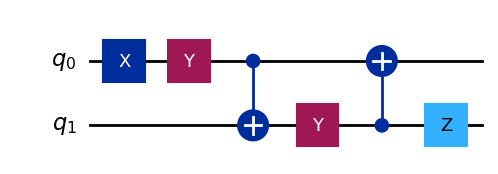

In [2]:
# If Block
if_sub = QuantumCircuit(2)

# Populate with gates
if_sub.x(0)
if_sub.y(0)
if_sub.cx(0, 1)
if_sub.y(1)
if_sub.cx(1, 0)
if_sub.z(1)

# Convert into instruction
if_sub_inst = if_sub.to_instruction(label='if_sub')

# Draw the circuit for visualization
if_sub.draw('mpl')

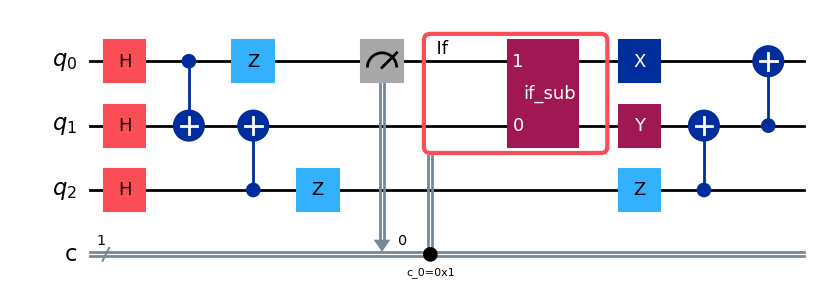

In [3]:
# Main Circuit
main_circuit = QuantumCircuit(3, 1)

# Populate with gates
main_circuit.h([0, 1, 2])
main_circuit.cx(0, 1)
main_circuit.cx(2, 1)
main_circuit.z([0, 2])

# Measure qubit-0
main_circuit.measure(0, 0)

# Add the if-else instruction based on condition on classical bit
with main_circuit.if_test((0, 1)) as else_block:
    main_circuit.append(if_sub_inst, qargs=[1, 0])
# with else_block:
#     

# More gates
main_circuit.x(0)
main_circuit.y(1)
main_circuit.z(2)
main_circuit.cx(2, 1)
main_circuit.cx(1, 0)

# Draw the main circuit
main_circuit.draw('mpl')

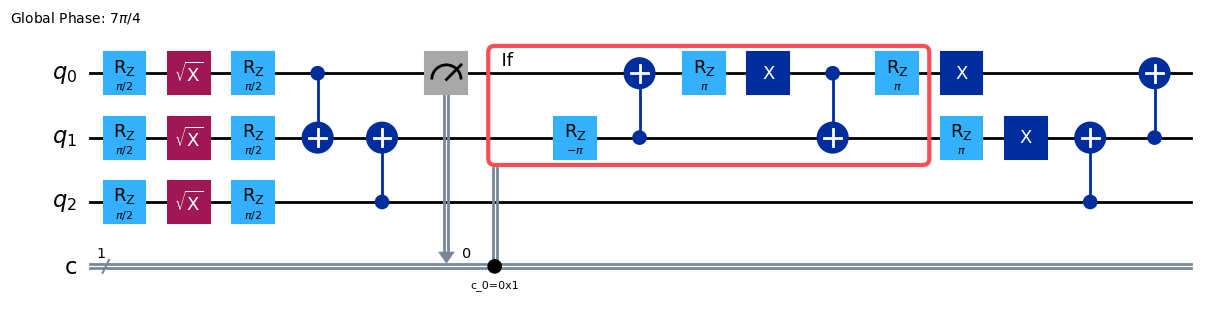

In [4]:
# Transpile the circuit
basis = ['rz', 'sx', 'x', 'cx']
dec = transpile(main_circuit, basis_gates=basis, optimization_level=3)

# Draw the decomposed circuit
dec.draw('mpl')

In [5]:
# Gate count
print("Gate count:", dec.count_ops())

# Gate depth
print("Gate depth:", dec.depth())

Gate count: OrderedDict({'rz': 7, 'cx': 4, 'sx': 3, 'x': 2, 'measure': 1, 'if_else': 1})
Gate depth: 10


### Following is the circuit when we assume that the if-condition does not hold!

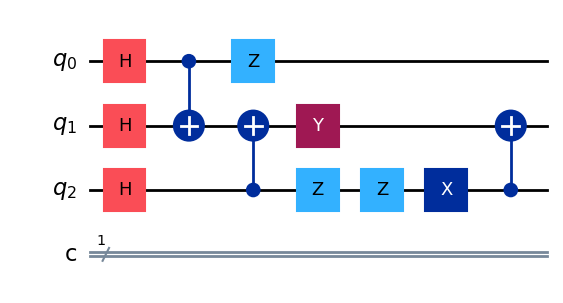

In [6]:
# Sample
qc_1 = QuantumCircuit(3, 1)
qc_1.h([0, 1, 2])
qc_1.cx(0, 1)
qc_1.cx(2, 1)
qc_1.z([0, 2])
qc_1.z(2)
qc_1.y(1)
qc_1.x(2)
qc_1.cx(2, 1)

# Decompose the circuit
dec_1 = qc_1.decompose()

# Draw the decomposed circuit
qc_1.draw('mpl')

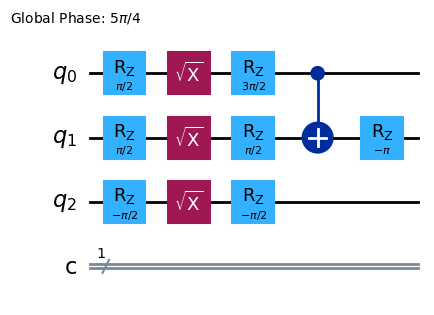

In [7]:
# Transpile the circuit
dec_1 = transpile(dec_1, basis_gates=basis, optimization_level=3)

# Draw the decomposed circuit
dec_1.draw('mpl')

### Reverse conditions when it does hold!

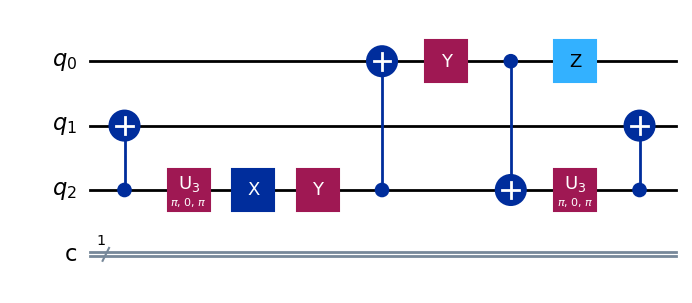

In [8]:
# Sample 2
qc_2 = QuantumCircuit(3, 1)

# Reverse changes
qc_2.cx(2, 1)
qc_2.x(2)

# Append block
qc_2.append(if_sub_inst, [2, 0])

# Add changes
qc_2.x(2)
qc_2.cx(2, 1)

# Decompose the circuit
dec_2 = qc_2.decompose()

# Draw the decomposed circuit
dec_2.draw('mpl')

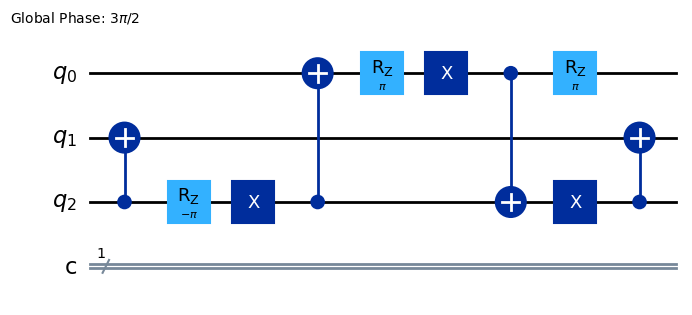

In [9]:
# Transpile the circuit
dec_2 = transpile(dec_2, basis_gates=basis, optimization_level=3)

# Draw the decomposed circuit
dec_2.draw('mpl')

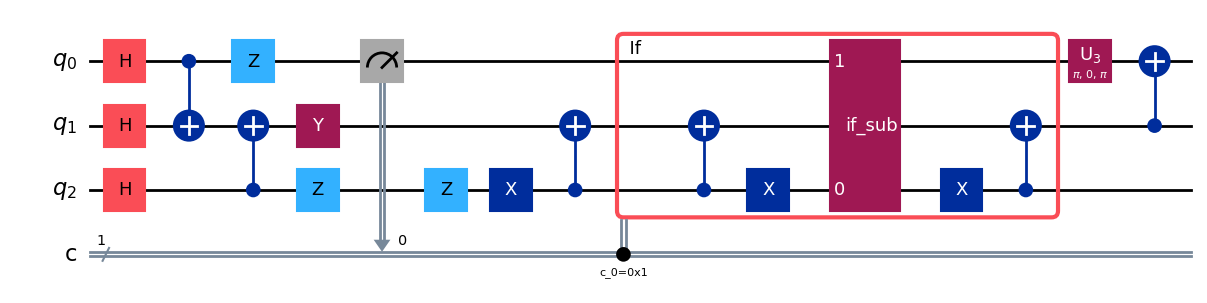

In [10]:
# New circuit with optimizations
main_2 = QuantumCircuit(3, 1)

# First block
qc_1_inst = qc_1.to_instruction()
main_2.append(qc_1_inst, qargs=[0, 1, 2], cargs=[0])

# Measure qubit-0
main_2.measure(0, 0)

# Conditional block
qc_2_inst = qc_2.to_instruction()
with main_2.if_test((0, 1)) as else_block:
    main_2.append(qc_2_inst, qargs=[0, 1, 2], cargs=[0])

# Add unoptimized gates
main_2.x(0)
main_2.cx(1, 0)

# Decompose the circuit
dec_3 = main_2.decompose()

# Draw the decomposed circuit
dec_3.draw('mpl')


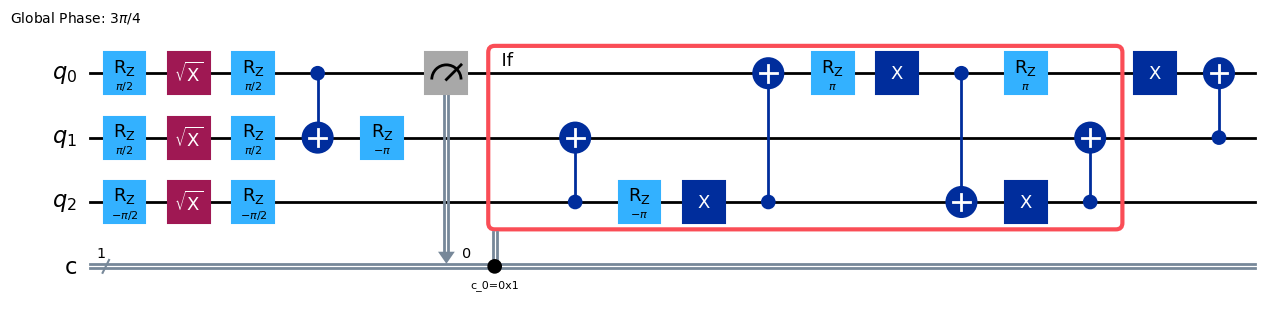

In [11]:
# Transpile the circuit
dec_3 = transpile(dec_3, basis_gates=basis, optimization_level=3)

# Draw the decomposed circuit
dec_3.draw('mpl')

In [12]:
# Gate count
print("Gate count:", dec_3.count_ops())

# Gate depth
print("Gate depth:", dec_3.depth())

Gate count: OrderedDict({'rz': 7, 'sx': 3, 'cx': 2, 'measure': 1, 'if_else': 1, 'x': 1})
Gate depth: 8


### Checking Correctness

In [13]:
# Generate a random qubit
import random
def random_qubit():
    a_real = random.uniform(-1, 1)
    a_imag = random.uniform(-1, 1)
    b_real = random.uniform(-1, 1)
    b_imag = random.uniform(-1, 1)

    a = complex(a_real, a_imag)
    b = complex(b_real, b_imag)

    norm = (abs(a) ** 2 + abs(b) ** 2) ** 0.5

    return a / norm, b / norm

In [14]:
# Get three qubits
q1 = random_qubit()
q2 = random_qubit()
q3 = random_qubit()

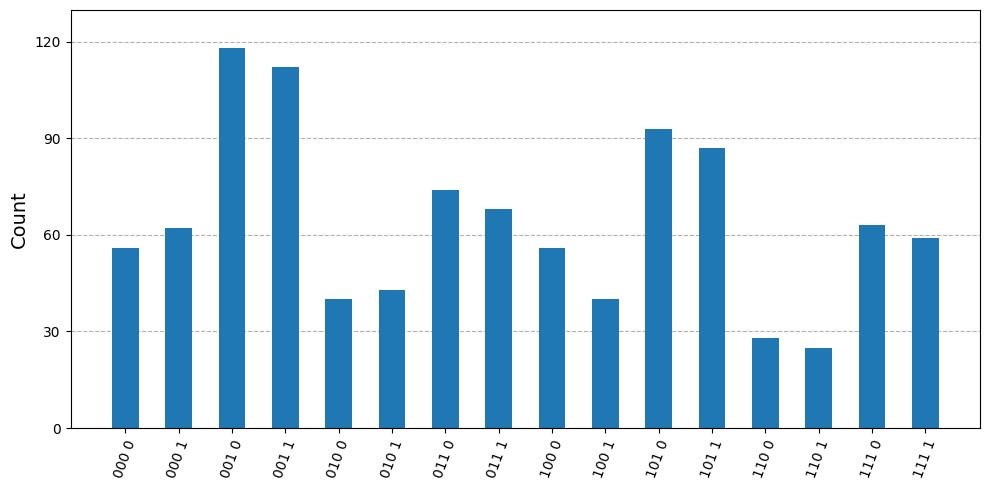

In [15]:
# Run dec on a simulator
from qiskit_aer import Aer

# Initialize the states
dec.initialize(q1, 0)
dec.initialize(q2, 1)
dec.initialize(q3, 2)

# Measure everything
dec.measure_all()

# Get the Aer simulator
backend = Aer.get_backend('aer_simulator')
dec = transpile(dec, backend)
results = backend.run(dec, shots=1024).result()

# Histogram
from qiskit.visualization import plot_histogram
plot_histogram(results.get_counts(dec), figsize=(10, 5), bar_labels=False)

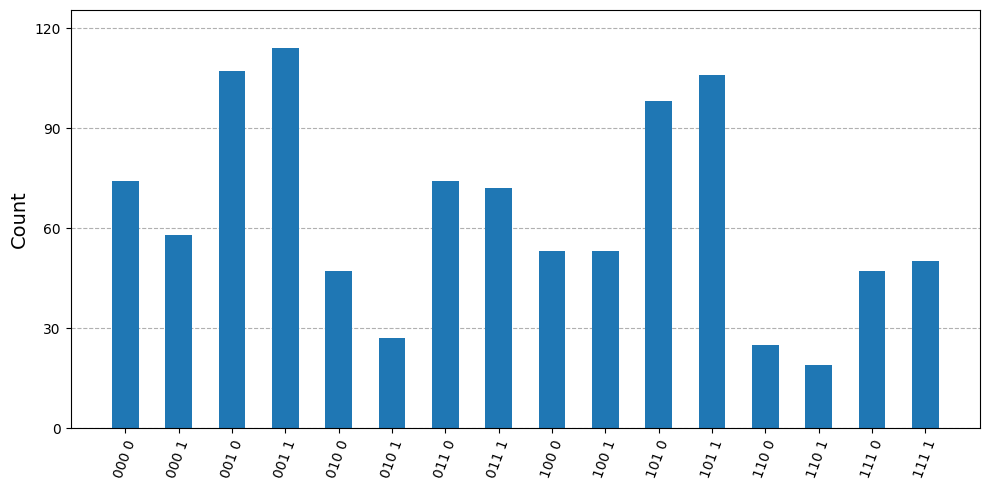

In [16]:
# Run dec_3 on a simulator
dec_3.initialize(q1, 0)
dec_3.initialize(q2, 1)
dec_3.initialize(q3, 2)

# Measure everything
dec_3.measure_all()

# Get the Aer simulator
backend = Aer.get_backend('aer_simulator')
dec_3 = transpile(dec_3, backend)
results_3 = backend.run(dec_3, shots=1024).result()

# Histogram
plot_histogram(results_3.get_counts(dec_3), figsize=(10, 5), bar_labels=False)
